In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

### Analyze Data

In [3]:
train_data=pd.read_csv('fraudTest.csv')

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  int64  
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

In [5]:
train_data.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,555719.000000,5.557190e+05,555719.000000,555719.000000,555719.000000,555719.000000,5.557190e+05,5.557190e+05,555719.000000,555719.000000,555719.000000
mean,277859.000000,4.178387e+17,69.392810,48842.628015,38.543253,-90.231325,8.822189e+04,1.380679e+09,38.542798,-90.231380,0.003860
std,160422.401459,1.309837e+18,156.745941,26855.283328,5.061336,13.721780,3.003909e+05,5.201104e+06,5.095829,13.733071,0.062008
min,0.000000,6.041621e+10,1.000000,1257.000000,20.027100,-165.672300,2.300000e+01,1.371817e+09,19.027422,-166.671575,0.000000
25%,138929.500000,1.800429e+14,9.630000,26292.000000,34.668900,-96.798000,7.410000e+02,1.376029e+09,34.755302,-96.905129,0.000000
50%,277859.000000,3.521417e+15,47.290000,48174.000000,39.371600,-87.476900,2.408000e+03,1.380762e+09,39.376593,-87.445204,0.000000
75%,416788.500000,4.635331e+15,83.010000,72011.000000,41.894800,-80.175200,1.968500e+04,1.385867e+09,41.954163,-80.264637,0.000000
max,555718.000000,4.992346e+18,22768.110000,99921.000000,65.689900,-67.950300,2.906700e+06,1.388534e+09,66.679297,-66.952026,1.000000


In [6]:
train_data.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [7]:
#separating data for analysis
fraud_counts=train_data['is_fraud'].value_counts()

legit_data=train_data[train_data.is_fraud==0]
fraud_data=train_data[train_data.is_fraud==1]

print(fraud_counts)


is_fraud
0    553574
1      2145
Name: count, dtype: int64


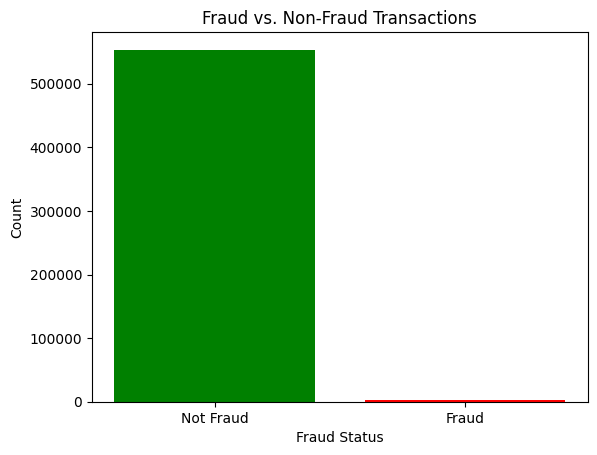

In [8]:
colors = ['green' if val == 0 else 'red' for val in fraud_counts.index]

# Plot the bar chart
plt.bar(fraud_counts.index, fraud_counts.values, color=colors)

# Customize the chart
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])  # Set labels for the x-axis
plt.xlabel('Fraud Status')
plt.ylabel('Count')
plt.title('Fraud vs. Non-Fraud Transactions')
plt.show()

In [9]:
missing_values = train_data.isnull().sum()
print(missing_values)

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


### Balancing Data

In [10]:
#legit data represents nr of legal transactions==nr of fraud transactions
legit_sample=legit_data.sample(n=2145)

In [11]:
balanced_dataset=pd.concat([legit_sample,fraud_data],axis=0)

In [12]:
balanced_dataset["is_fraud"].value_counts()

is_fraud
0    2145
1    2145
Name: count, dtype: int64

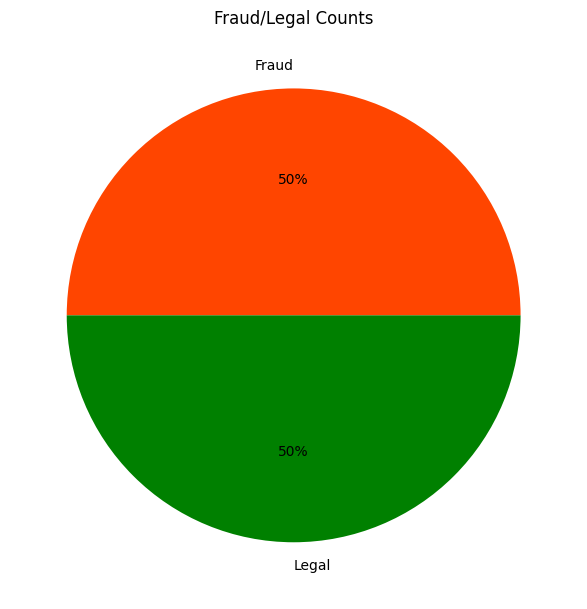

In [28]:
exit_counts = balanced_dataset["is_fraud"].value_counts()
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Subplot for the pie chart
plt.pie(exit_counts, labels=["Fraud", "Legal"], autopct="%0.0f%%",colors=["orangered","green"])
plt.title("Fraud/Legal Counts")
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [15]:
#Tranform to datetime to can read data as strings

balanced_dataset['trans_date_trans_time']=pd.to_datetime(balanced_dataset['trans_date_trans_time'])

balanced_dataset["dob"]=pd.to_datetime(balanced_dataset["dob"])

In [16]:
#Clean Data from unusseful columns

balanced_dataset.drop(columns=['Unnamed: 0','cc_num','first', 'last', 'street', 'city', 'state', 'zip', 'dob', 'trans_num','trans_date_trans_time'],inplace=True)
balanced_dataset

,merchant,category,amt,gender,lat,long,city_pop,job,unix_time,merch_lat,merch_long,is_fraud
380116,fraud_Bechtelar-Rippin,food_dining,65.55,M,39.0965,-84.6431,177,Exhibition designer,1384618498,38.840658,-84.147218,0
501404,"fraud_Zieme, Bode and Dooley",gas_transport,41.19,M,40.9918,-73.9800,4664,"Radiographer, diagnostic",1387529244,41.973102,-74.438314,0
70648,"fraud_Robel, Cummerata and Prosacco",gas_transport,94.10,M,37.7773,-119.0825,633,Health service manager,1373881660,36.904737,-119.751889,0
33040,"fraud_Ledner, Hartmann and Feest",health_fitness,75.62,F,30.4066,-91.1468,378909,"Designer, furniture",1372777643,29.555139,-90.269441,0
31033,"fraud_Schiller, Blanda and Johnson",home,74.57,M,44.6437,-90.1031,828,Arts development officer,1372690017,44.356303,-90.127684,0
...,...,...,...,...,...,...,...,...,...,...,...,...
517197,"fraud_Willms, Kris and Bergnaum",shopping_pos,1041.51,M,34.6323,-89.8855,14462,Database administrator,1387749948,34.573471,-89.911011,1
517274,fraud_Kuhn LLC,shopping_pos,868.09,M,34.6323,-89.8855,14462,Database administrator,1387750687,34.091227,-90.390612,1
517341,"fraud_Mosciski, Ziemann and Farrell",shopping_net,1039.42,M,34.6323,-89.8855,14462,Database administrator,1387751508,34.628434,-90.284780,1
517529,fraud_Bauch-Raynor,grocery_pos,289.27,M,34.6323,-89.8855,14462,Database administrator,1387753563,34.746063,-90.401093,1


### Processing data

In [17]:
#Tranform important data to numeric values
encoder = LabelEncoder()
categorical_columns = ['merchant', 'category', 'gender', 'job']
for col in categorical_columns:
    balanced_dataset[col] = encoder.fit_transform(balanced_dataset[col])

In [18]:
#Devide data 
X = balanced_dataset.drop(columns=['is_fraud'])
y = balanced_dataset['is_fraud']

In [19]:
#Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.3,random_state=42,stratify=y)

In [21]:
def evaluate_model(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    y_prob=model.predict_proba(X_test)[:,1] if hasattr(model,"predict_proba") else None

    # Evaluation for different arhitecture models(Regresion,XGBOOST,Decision Tree)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    if y_prob is not None:
        auc_score = roc_auc_score(y_test, y_prob)
        print(f"AUC-ROC Score: {auc_score:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=['Not Fraud', 'Fraud']).plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {model.__class__.__name__}")
    plt.show()

## Logistic Regression


Evaluating Logistic Regression...

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.94      0.86       644
           1       0.92      0.75      0.83       643

    accuracy                           0.84      1287
   macro avg       0.86      0.84      0.84      1287
weighted avg       0.86      0.84      0.84      1287

AUC-ROC Score: 0.8500


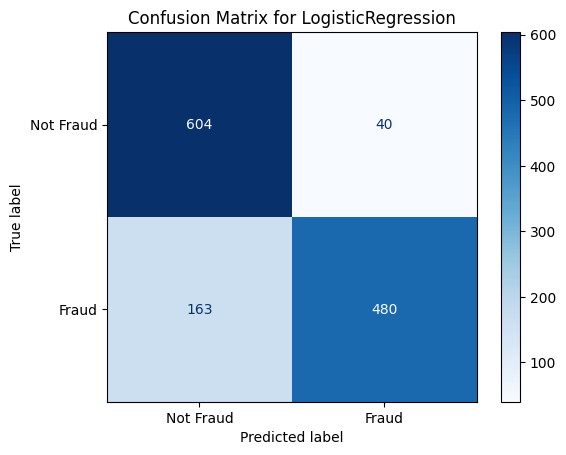

In [22]:
log_reg = LogisticRegression(class_weight='balanced', random_state=42)
print("\nEvaluating Logistic Regression...")
evaluate_model(log_reg, X_train, y_train, X_test, y_test)

## Decision Tree 


Evaluating Decision Tree...

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       644
           1       0.96      0.84      0.90       643

    accuracy                           0.91      1287
   macro avg       0.91      0.91      0.90      1287
weighted avg       0.91      0.91      0.90      1287

AUC-ROC Score: 0.9692


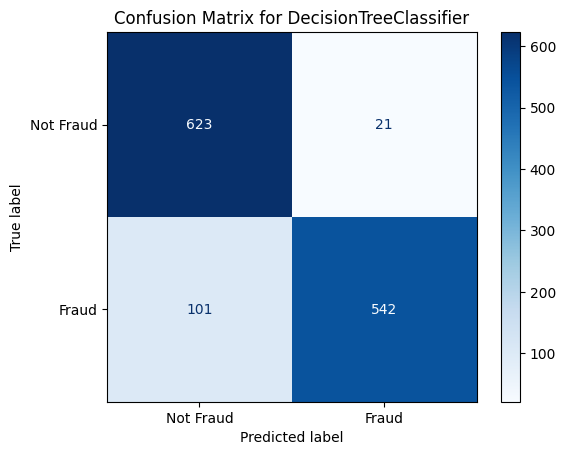

In [23]:
decision_tree = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced')
print("\nEvaluating Decision Tree...")
evaluate_model(decision_tree, X_train, y_train, X_test, y_test)

## XGBoost


Evaluating XGBoost...


d:\Machine_Learning\Project_Sigmoid\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:15:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       644
           1       0.96      0.97      0.97       643

    accuracy                           0.97      1287
   macro avg       0.97      0.97      0.97      1287
weighted avg       0.97      0.97      0.97      1287

AUC-ROC Score: 0.9934


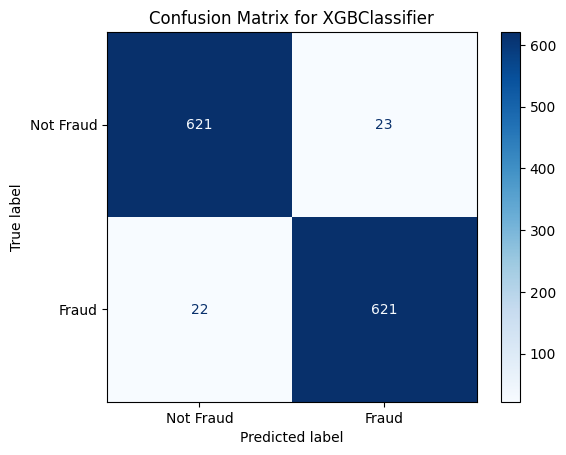

In [24]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
print("\nEvaluating XGBoost...")
evaluate_model(xgb_model, X_train, y_train, X_test, y_test)